In [1]:
from ucimlrepo import fetch_ucirepo 
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
import time

In [2]:
RANDOM_STATE = 101

### Load Data

In [3]:
# Wine Quality Data
# fetch dataset 
wq_df = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = wq_df.data.features 
y = wq_df.data.targets 

#### Balancing dataset

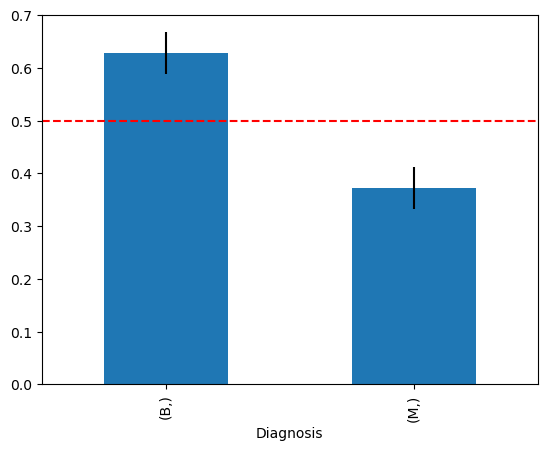

In [4]:
freqs =y.value_counts() /len(y)
std_errors = np.sqrt(freqs*(1-freqs)/len(y))
expected_frequency = 1/len(np.unique(y))

freqs.plot(kind='bar',yerr=std_errors*1.96)

plt.axhline(expected_frequency,color='red',linestyle='--')

### Model

#### Default

In [5]:
# Split into training and testing sets. Don't use test set until the very end
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE, stratify = y)

In [6]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True)
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])
pipeline.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('norm', MinMaxScaler()), ('sm', SMOTE(random_state=101)),
                ('model',
                 MLPClassifier(early_stopping=True, max_iter=2000,
                               random_state=101))])

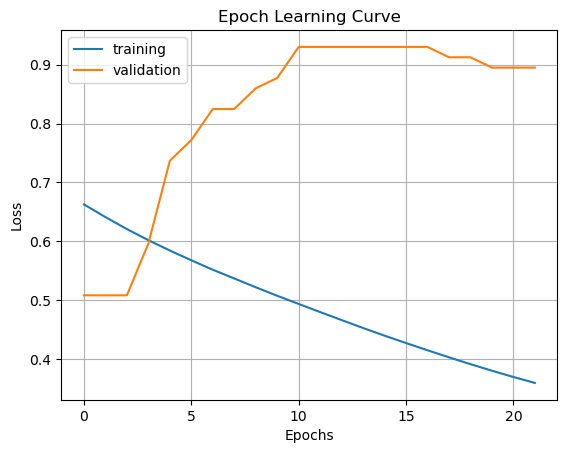

In [7]:
# Epoch Learning Curve

plt.figure()
plt.plot(pipeline['model'].loss_curve_, label='training')
plt.plot(pipeline['model'].validation_scores_, label='validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Epoch Learning Curve')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [8]:
y_pred = pipeline.predict(X_test)

In [9]:
# print classification report 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           B       0.96      0.69      0.81        72
           M       0.65      0.95      0.77        42

    accuracy                           0.79       114
   macro avg       0.80      0.82      0.79       114
weighted avg       0.84      0.79      0.79       114



In [10]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True)
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])
train_sizes, train_scores, validation_scores = learning_curve(
estimator = pipeline,
X = X_train,
y = y_train.values.ravel(), cv = 5,
scoring = 'f1_macro',
random_state=RANDOM_STATE)

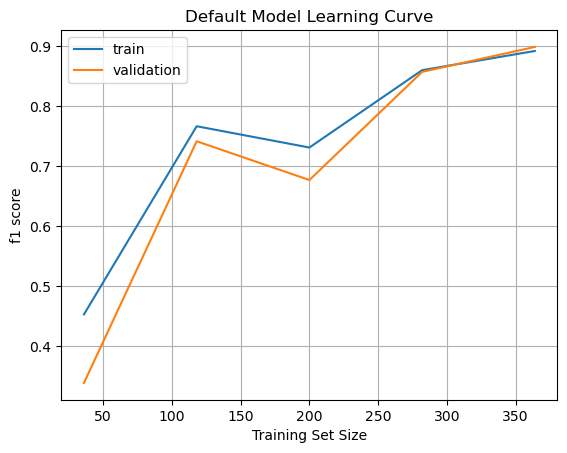

In [11]:
train_mean = train_scores.mean(axis=1)
validation_mean = validation_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, validation_mean, label="validation")

plt.title("Default Model Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("f1 score")
plt.legend(loc="best")
plt.grid()

plt.show()

#### Final Model

In [12]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=.1, hidden_layer_sizes=(100,100,100))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])
t0 = time.time()
pipeline.fit(X_train, y_train.values.ravel())
print("Training time:", time.time()-t0)

Training time: 0.11548280715942383


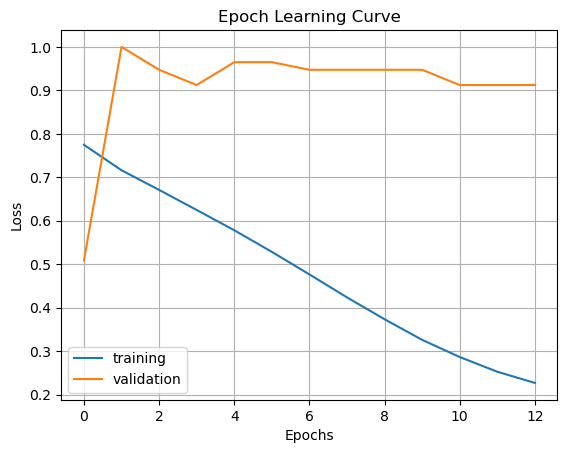

In [13]:
# Epoch Learning Curve

plt.figure()
plt.plot(pipeline['model'].loss_curve_, label='training')
plt.plot(pipeline['model'].validation_scores_, label='validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Epoch Learning Curve')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [14]:
y_pred = pipeline.predict(X_test)

In [15]:
# print classification report 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           B       0.93      0.96      0.95        72
           M       0.93      0.88      0.90        42

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



In [16]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = pipeline,
X = X_train,
y = y_train.values.ravel(), cv = 5,
scoring = 'f1_macro',
random_state=RANDOM_STATE)

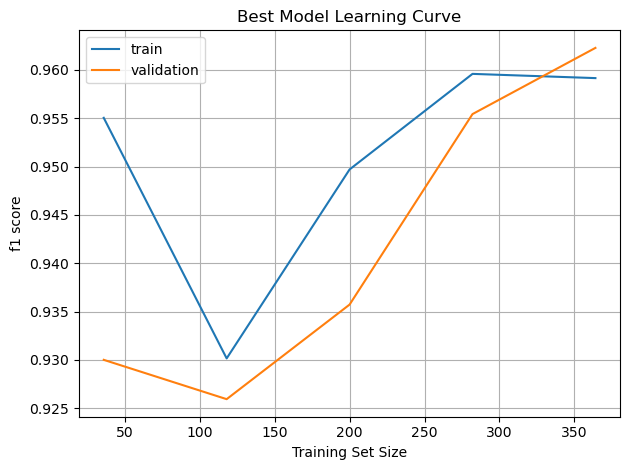

In [17]:
train_mean = train_scores.mean(axis=1)
validation_mean = validation_scores.mean(axis=1)


plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, validation_mean, label="validation")

plt.title("Best Model Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("f1 score")
plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.savefig('breast_cancer_plots/nn_bc_best_learning_curve.png')
plt.show()

#### Sub/Optimal Learning Curve

In [18]:
from sklearn.model_selection import StratifiedKFold

In [19]:
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

In [20]:
losses_sub = []
vals_sub = []
losses_op = []
vals_op = []

In [21]:
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    print('Fold: ', i)
    x_train_fold, x_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=.1, hidden_layer_sizes=(100,100,100,100))
    sm = SMOTE(random_state=RANDOM_STATE)
    norm = MinMaxScaler()
    pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])

    pipeline.fit(x_train_fold, y_train_fold.values.ravel())


    losses_sub.append(pipeline['model'].loss_curve_)
    vals_sub.append(pipeline['model'].validation_scores_)

    clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=.1, hidden_layer_sizes=(100,100,100))
    sm = SMOTE(random_state=RANDOM_STATE)
    norm = MinMaxScaler()
    pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])
    pipeline.fit(x_train_fold, y_train_fold.values.ravel())



    losses_op.append(pipeline['model'].loss_curve_)
    vals_op.append(pipeline['model'].validation_scores_)

Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4


In [22]:
losses_sub = pd.DataFrame(losses_sub).mean()
vals_sub = pd.DataFrame(vals_sub).mean()
losses_op = pd.DataFrame(losses_op).mean()
vals_op = pd.DataFrame(vals_op).mean()

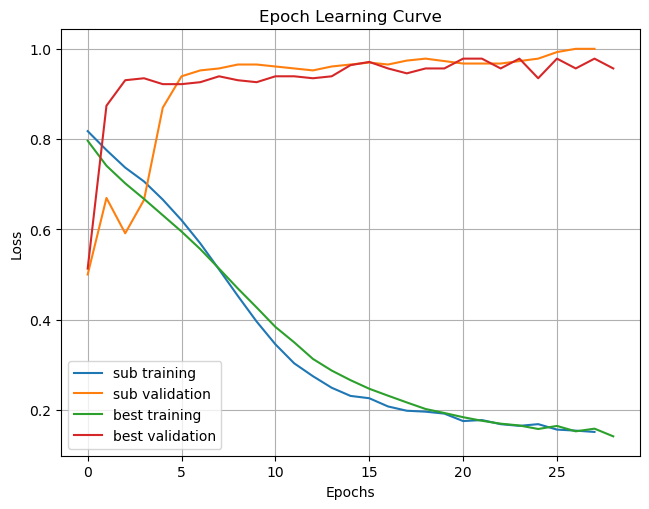

In [23]:
# Epoch Learning Curve

plt.figure()
plt.plot(losses_sub, label='sub training')
plt.plot(vals_sub, label='sub validation')

plt.plot(losses_op, label='best training')
plt.plot(vals_op, label='best validation')
plt.tight_layout()

plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Epoch Learning Curve')
plt.ylabel('Loss')
plt.grid()
plt.savefig('breast_cancer_plots/nn_bc_combo_epoch_learning_curve.png')
plt.show()

In [24]:
# Suboptimal Model
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=.1, hidden_layer_sizes=(100,100,100,100))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])
pipeline.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('norm', MinMaxScaler()), ('sm', SMOTE(random_state=101)),
                ('model',
                 MLPClassifier(alpha=0.1, early_stopping=True,
                               hidden_layer_sizes=(100, 100, 100, 100),
                               max_iter=2000, random_state=101))])

In [25]:
y_pred = pipeline.predict(X_test)

In [26]:
# print classification report 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           B       0.96      0.92      0.94        72
           M       0.87      0.93      0.90        42

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114



In [27]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, alpha=.1, early_stopping=True, hidden_layer_sizes=(100,100,100,100))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])

train_sizes, train_scores, validation_scores = learning_curve(
estimator = pipeline,
X = X_train,
y = y_train.values.ravel(), cv = 5,
scoring = 'f1_macro',
random_state=RANDOM_STATE)

clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=.1, hidden_layer_sizes=(100,100,100))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])

train_sizes1, train_scores1, validation_scores1 = learning_curve(
estimator = pipeline,
X = X_train,
y = y_train.values.ravel(), cv = 5,
scoring = 'f1_macro',
random_state=RANDOM_STATE)

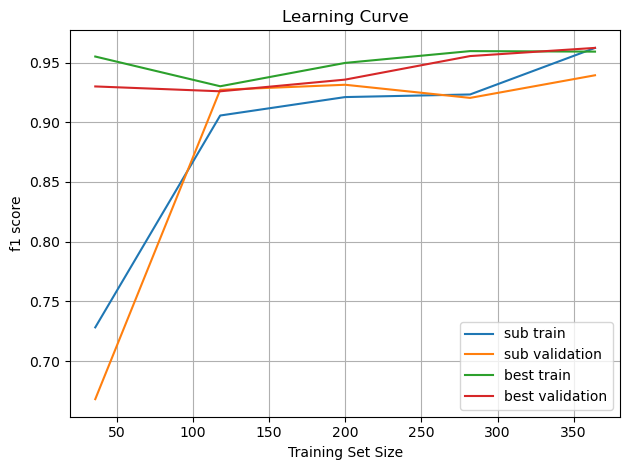

In [28]:
train_mean = train_scores.mean(axis=1)
validation_mean = validation_scores.mean(axis=1)
train_mean1 = train_scores1.mean(axis=1)
validation_mean1 = validation_scores1.mean(axis=1)

plt.plot(train_sizes, train_mean, label="sub train")
plt.plot(train_sizes, validation_mean, label="sub validation")
plt.plot(train_sizes1, train_mean1, label="best train")
plt.plot(train_sizes1, validation_mean1, label="best validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("f1 score")
plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.savefig('breast_cancer_plots/nn_bc_combo_learning_curve.png')
plt.show()

### Validation Plot

In [29]:
from sklearn.model_selection import validation_curve
import numpy as np

#### Width

In [30]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True)
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])

In [31]:
parameter_range = [(5,), (10,), (20,), (50,), (100,), (150,), (200,), (250,), (300,)]
train_score, test_score = validation_curve(pipeline, X_train, y_train.values.ravel(),
                                           param_name="model__hidden_layer_sizes",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_macro")

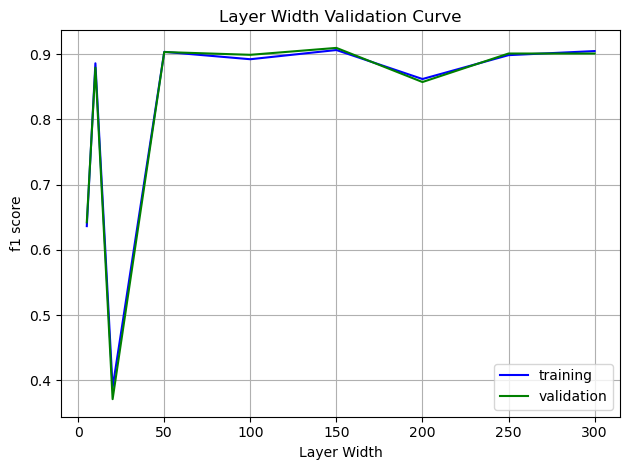

In [32]:
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

parameter_range = [5, 10, 20, 50, 100, 150, 200, 250, 300]
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="training", color='b')
plt.plot(parameter_range, mean_test_score,
         label="validation", color='g')
 
# Creating the plot
plt.title("Layer Width Validation Curve")
plt.xlabel("Layer Width")
plt.ylabel("f1 score")
plt.tight_layout()
plt.legend(loc='best')
plt.grid()
plt.savefig('breast_cancer_plots/nn_bc_layer_width_validation_curve.png')
plt.show()

#### Depth

In [33]:
parameter_range = [(100,), (100,100), (100,100,100), (100,100,100,100)]
    # (5,), (5,5), (5,5,5), (5,5,5,5), (5,5,5,5,5), (5,5,5,5,5,5)]
                   # , (10,), (10,10), (10,10,10), (10,10,10,10)]
train_score, test_score = validation_curve(pipeline, X_train, y_train.values.ravel(),
                                           param_name="model__hidden_layer_sizes",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_macro")

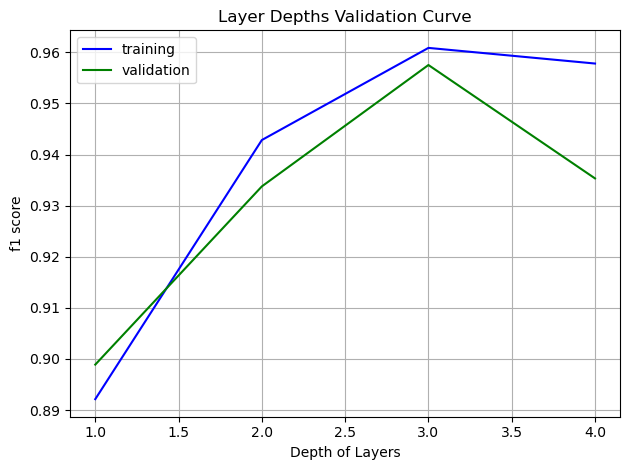

In [34]:
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

parameter_range = [1, 2, 3, 4]
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="training", color='b')
plt.plot(parameter_range, mean_test_score,
         label="validation", color='g')
 
# Creating the plot
plt.title("Layer Depths Validation Curve")
plt.xlabel("Depth of Layers")
plt.ylabel("f1 score")
plt.tight_layout()
plt.legend(loc='best')
plt.grid()
plt.savefig('breast_cancer_plots/nn_bc_layer_depth_validation_curve.png')
plt.show()

#### Alpha

In [35]:
parameter_range = [0.0001, 0.01, 0.05, 0.1, 0.5, 0.75]
train_score, test_score = validation_curve(pipeline, X_train, y_train.values.ravel(),
                                           param_name="model__alpha",
                                           param_range=parameter_range,
                                           cv=5, scoring="f1_macro")

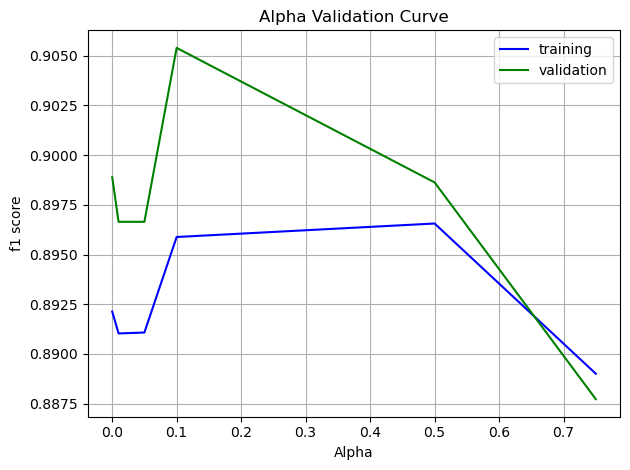

In [36]:
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         label="training", color='b')
plt.plot(parameter_range, mean_test_score,
         label="validation", color='g')
 
# Creating the plot
plt.title("Alpha Validation Curve")
plt.xlabel("Alpha")
plt.ylabel("f1 score")
plt.tight_layout()
plt.legend(loc='best')
plt.grid()
plt.savefig('breast_cancer_plots/nn_bc_alpha_validation_curve.png')
plt.show()

### Grid Search

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True)
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])
params = [{'model__hidden_layer_sizes':[(20,), (50,), (100,), (100,100), (100,100,100)],
          'model__alpha': [.0001, .001, .01, .1]}]
grid = GridSearchCV(pipeline,
                      param_grid=params,
                      scoring='f1_macro',
                      cv=5)
grid.fit(X_train, y_train.values.ravel())
print(grid.best_params_) 
grid_predictions = grid.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions))  

{'model__alpha': 0.1, 'model__hidden_layer_sizes': (100, 100, 100)}
              precision    recall  f1-score   support

           B       0.93      0.96      0.95        72
           M       0.93      0.88      0.90        42

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114

